#신경망, 딥러닝

딥러닝
- 머신러닝의 한 방법
- 뇌의 신경 네트워크에서 힌트를 얻음
- 층을 많이 활용한 모델

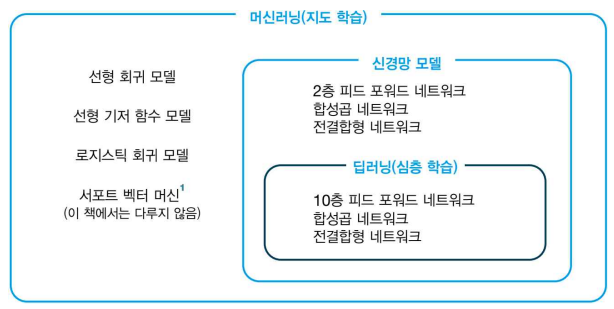

신경망 모델 : 뉴런 모델 단위로 구축

인간의 신경세포는 막전위가 한계치를 초과하면 전기적 펄스를 발신하여 축삭을 타고 다음 신경 세포로 전달됨

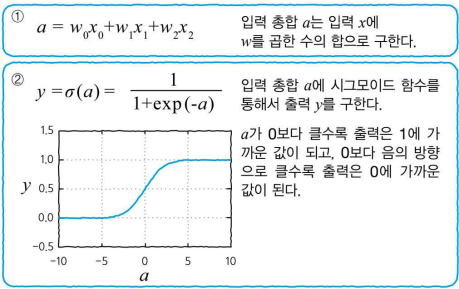

a는 입력 총합이고, 막전위에 비유된다.

y는 0부터 1까지 연속된 값을 갖는다. 출력 값은 단위 시간당 펄스 수를 나타낸다.

a가 클 수록 발화 빈도는 1에 가까워지고, a가 작아질수록 0에 가까워지며 발화가 거의 하지 않은 상태가 된다.

###2층 피드 포워드 신경망
신호가 되돌아가는 경로가 없이 한 방향으로만 흐르는 신경망

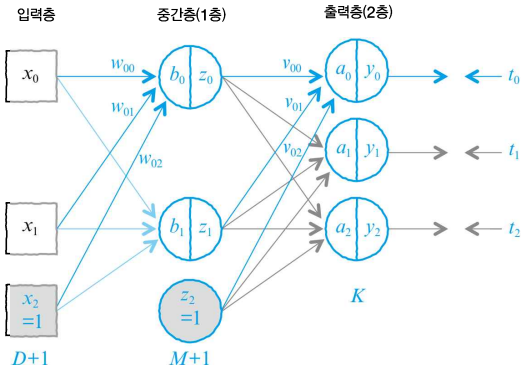

회색 입력 : bias

2차원의 입력과 3개의 카테고리 분류(출력)

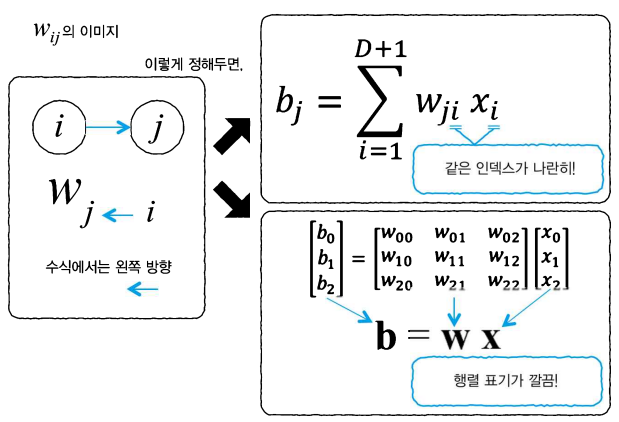

입력 차원을 D, 중간층 뉴런의 수를 M, 출력 차원을 K로 한 경우

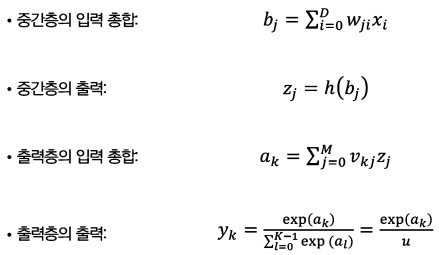

In [ ]:
import numpy as np

np.random.seed(seed=1)
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # x0의 범위, 표시용
X_range1 = [-3, 3] # x1의 범위
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      T[n, k] = 1
      break
  for k in range(2):
    X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]

오버피팅이 일어나고 있지 않은지 확인용 데이터 저장

In [ ]:
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

np.savez('class_data.npz', X_train = X_train, T_train = T_train, X_test = X_test, T_test = T_test, X_range0 = X_range0, X_range1 = X_range1)

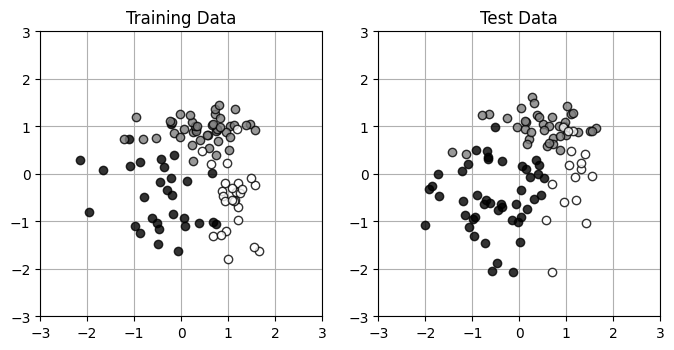

In [ ]:
# 분할한 데이터 그리기
import matplotlib.pyplot as plt
%matplotlib inline

# 분포 표시용 함수
def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0],[.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
             linestyle='none',
             marker='o', markeredgecolor='black',
             color=c[i], alpha=0.8)
    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

피드포워드 네트워크 FNN함수 인수와 출력

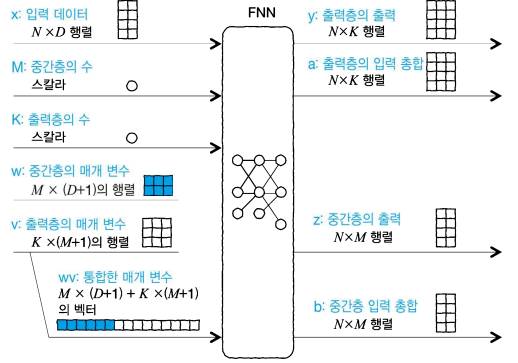

In [ ]:
def Sigmoid(x):
  y = 1/(1 + np.exp(-x))
  return y

def FNN(wv, M, K, x):
  N, D = x.shape
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))# 중간층의 매개 변수
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))# 출력층의 매개 변수
  b = np.zeros((N, M + 1))# 중간층 입력 총합
  z = np.zeros((N, M + 1))# 중간층의 출력
  a = np.zeros((N, K))# 출력층의 입력 총합
  y = np.zeros((N, K))# 출력층의 출력
  for n in range(N):
    for m in range(M):
      b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])
      z[n, m] = Sigmoid(b[n, m])
    z[n, M] = 1
    wkz = 0
    for k in range(K):
      a[n, k] = np.dot(v[k, :], z[n, :])
      wkz = wkz + np.exp(a[n, k])
    for k in range(K):
      y[n, k] = np.exp(a[n, k]) / wkz
  return y, a, z, b

# 행 동작 체크
WV = np.ones(15)
M = 2
K = 3 # wv는 길이가 2*3 + 3*3 = 15인 가중치 벡터
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

- N개의 데이터를 한 번에 처리할 수 있음
- x를 데이터의 수 N * D
- y를 데이터의 수 N * K
- y의 요소는 클래스 0, 1, 2에 속해 있을 확률(더하면 1)
- M, K는 중간층과 출력의 차원으로 자유롭게 바꿀 수 있음
- W, V는 중간층, 출력층 가중치이며 한 덩어리로 한 벡터 wv로 전달함(최적화 프로그램 만들기 쉬움)

###수치 미분법
분류문제이기 때문에 평균 교차 엔트로피 오차 사용

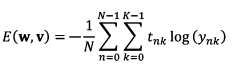

성실하게 미분해서 기울기를 구하지 않아도 매우 작은 숫자 만큼의 앞의 지점에서와의 기울기 근사 하면 미분한 것과 비슷한 효과

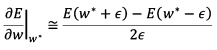

매개변수가 여러개일 경우 하나의 매개변수를 제외한 나머지 매개변수는 고정시킨 후 편미분 근사하는 과정 반복

단점은 정밀도의 오차가 아닌 계산 비용

In [ ]:
# 평균 교차 엔트로피 오차
def CE_FNN(wv, M, K, x, t):
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x)
  ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
  return ce

# 동작 체크
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


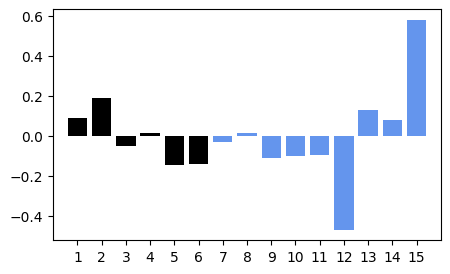

In [ ]:
def dCE_FNN_num(wv, M, K, x, t):
  epsilon = 0.001 # 입실론 정의
  dwv = np.zeros_like(wv)
  for iwv in range(len(wv)):
    wv_modified = wv.copy()
    wv_modified[iwv] = wv[iwv] - epsilon
    mse1 = CE_FNN(wv_modified, M, K, x, t)
    wv_modified[iwv] = wv[iwv] + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t)
    dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
  return dwv

def Show_WV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color="black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
          align="center", color="cornflowerblue")
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

15개의 가중치 매개변수 각각에 대한 수치 미분 값(편미분 값)

In [ ]:
import time

# 분류 문제를 경사 하강법으로 풀기
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wvt = wv_init # 가중치의 초기값
  err_train = np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n): # 학습 단계 수
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train) # 매번 훈련데이터 오차와 테스트 데이터 오차 계산
    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wvt, M, K, x_test, t_test) # 학습 단계별로 오버피팅 확인
    wv_hist[i, :] = wvt
  return wvt, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 0.5 # 학습 상수
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:122.919 sec


훈련 데이터 오차 단조롭게 감소, 오버피팅 X

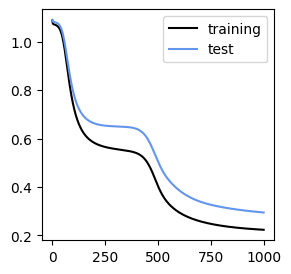

In [ ]:
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.show()

수렴한 줄 알았던 가중치가 급격히 학습이 진행되는 부분 보임

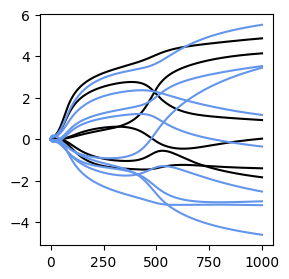

In [ ]:
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

가중치의 시간 변화

중간층의 가중치 w -> 검정

출력층의 가중치 v -> 파랑

- 400단계 부근에서 각각의 가중치 그래프 교차
- 가중치를 갱신하는 방향, 오차 함수의 기울기의 방향이 변화
- 안장점 지점 근처를 통과했을거라 예측

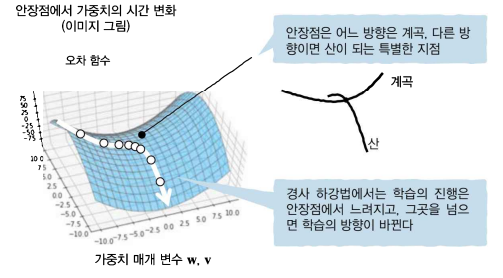

2차원의 가중치라고 가정한 그래프

학습이 수렴해도 더 노력하면 학습이 단숨에 진행되는 경우 많음 -> 학습 단계 수 결정 중요

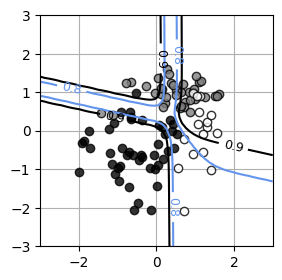

In [ ]:
# 경계선 표시 함수
def show_FNN(wv, M, K):
  xn = 60
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
  y, a, z, b = FNN(wv, M, K, x)
  plt.figure(1, figsize=(4, 4))
  for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                       colors=['cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

학습에 사용하지 않은 테스트 데이터만 플롯

각각의 클래스에 0.5 또는 0.9이상으로 판정한 영역의 경계를 표시

###오차 역전파법
피드 포워드 신경망에 학습시키는 방법

네트워크의 출력에서 발생하는 오차의 정보를 사용

출력층의 가중치에서 중간층의 가중치로 입력의 반대 방향으로 가중치 갱신

경사하강법에서 자연스레 도출된 법칙

평균 상호 엔트로피 오차 : 데이터 각각의 상호 엔트로피 오차의 평균

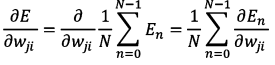

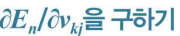

편미분의 연쇄율을 사용하여 두 미분의 곱으로 분해

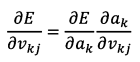

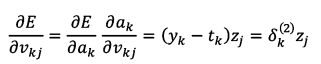

Vkj의 갱신규칙

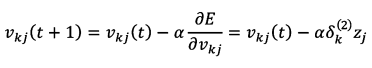

Vkj는 중간층의 뉴런 j에서 출력층의 뉴런 k에 정보를 전달하는 결합의 가중치

결합의 변경의 크기는 입력의 크기와 오차의 곱으로 결정됨 시그모이드 함수 -> 항상 0~1양수값

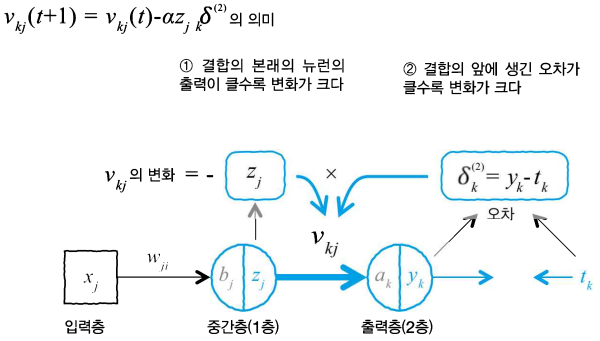

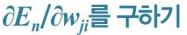

이것도 오차함수 E를 Wji로 편미분 하는 것

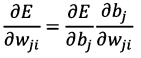

Wji의 갱신 규칙

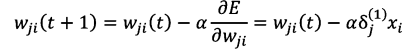

결합 전에 발생한 오차와 결합 본래의 입력에 비례하는 형태로 변경된 것

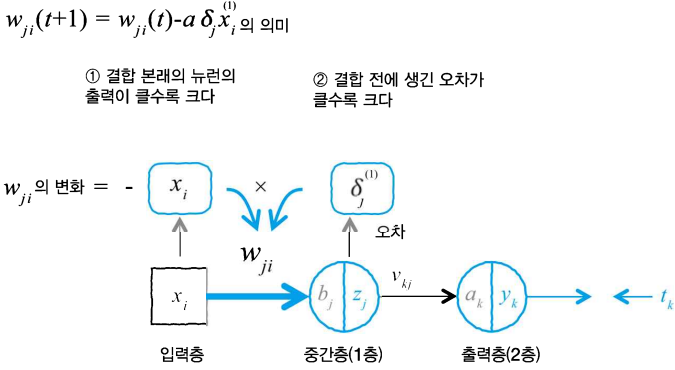

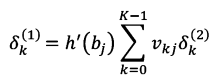

처음의 h'는 활성화 함수의 미분, 항상 양수

결합한 곳에서 생긴 오차를 반대 방향으로 전달시켜 계산함

정리

1. 네트워크에 x입력, y출력. 중간에 계산된 weight보유
2. 출력 y와 데이터 t비교, 오차 계산. 오차는 출력층의 각 뉴런에 할당
3. 출력층의 오차를 사용하여 중간층의 오차 계산
4. 결합 본래의 신호 강도와 결합처의 오차 정보 사용해 weight갱신

###오차 역전파법 구현

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


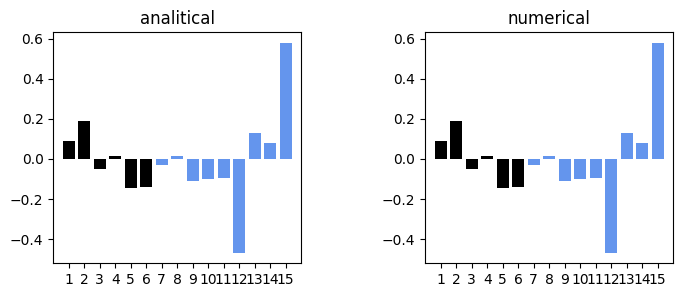

In [ ]:
# 해석적 미분
def dCE_FNN(wv, M, K, x, t):
  N, D = x.shape
  # wv을 w와 v로 되돌림
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))
  # x를 입력하여 y를 얻음
  y, a, z, b = FNN(wv, M, K, x)
  # 출력 변수의 준비
  dwv = np.zeros_like(wv)
  dw = np.zeros((M, D + 1))
  dv = np.zeros((K, M + 1))
  delta1 = np.zeros(M) # 1층 오차
  delta2 = np.zeros(K) # 2층 오차 (k = 0인 부분은 사용 안 함)
  for n in range(N):
    # 출력층의 오차 구하기
    for k in range(K):
      delta2[k] = (y[n, k] - t[n, k])
    # 중간층의 오차 구하기
    for j in range(M):
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
    # v의 기울기 dv를 구하기
    for k in range(K):
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
    # w의 기울기 dw를 구하기
    for j in range(M):
      dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
  # dw와 dv를 합체시킨 dwv로 만들기
  dwv = np.c_[dw.reshape((1, M * (D + 1))),
              dv.reshape((1, K * (M + 1)))]
  dwv = dwv.reshape(-1)
  return dwv

def Show_dWV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3],
          align = "center", color = "black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
          align="center", color='cornflowerblue')
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

# 동작 확인
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

해석적 미분값, 수치 미분값 거의 동일

In [ ]:
import time

# 해석적 미분법을 사용한 경사 하강법
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wv = wv_init.copy()
  err_train =  np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n):
    wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train)
    err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
    wv_hist[i, :] = wv
  return wv, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:14.992 sec


수치 미분에 비해 훨씬 빨라진 계산 속도

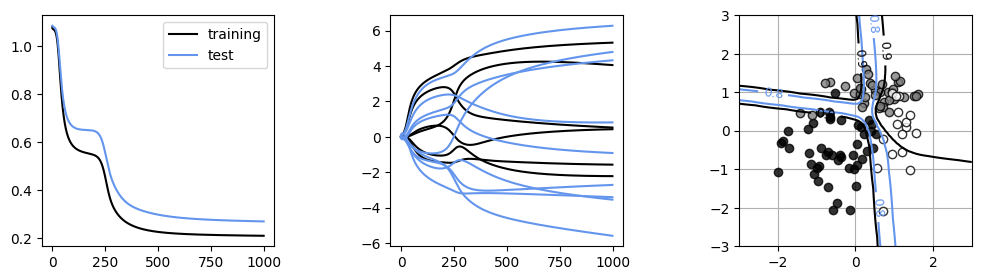

In [ ]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

해석적 미분을 통한 경사 하강법 실행 결과

수치 미분은 도출된 미분 방정식이 맞는지 확인하는 도구 -> 먼저 올바른 값을 구해두는 것이 좋다

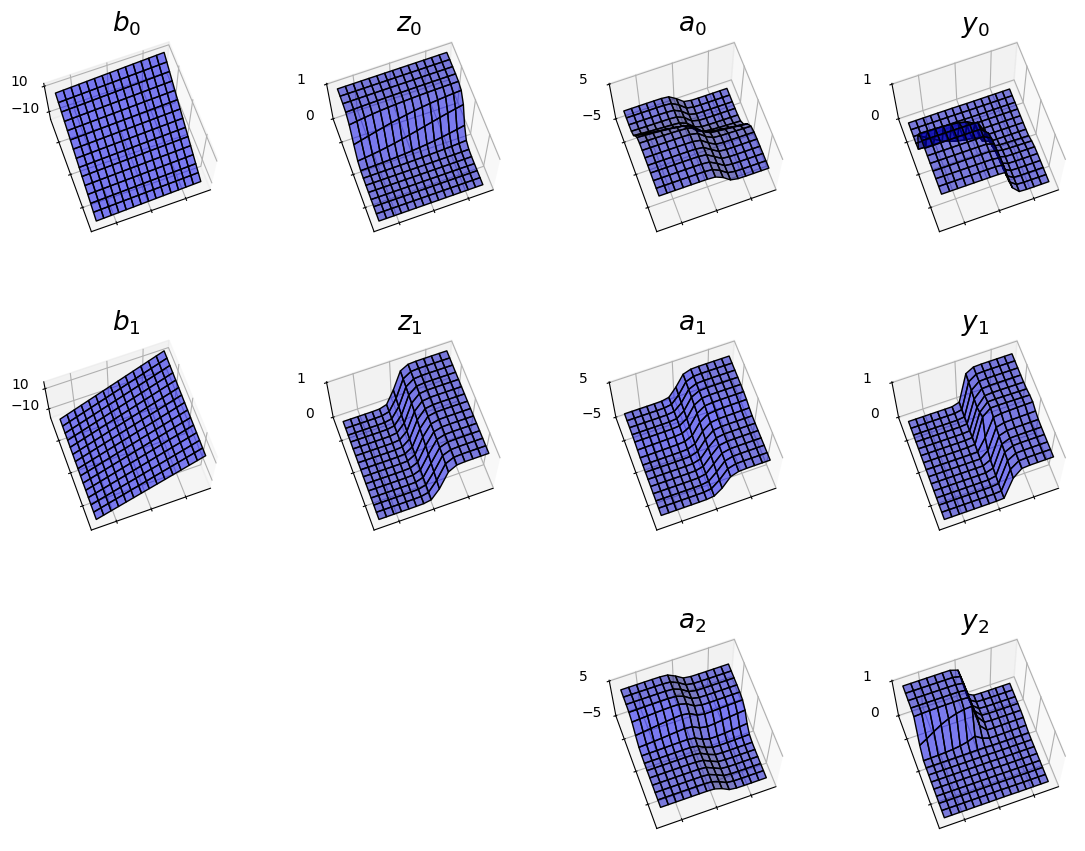

In [ ]:
def show_activation3d(ax, v, v_ticks, title_str):
  f = v.copy()
  f = f.reshape(xn, xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, color="blue", edgecolor="black",
                  rstride=1, cstride=1, alpha=0.5)
  ax.view_init(70, -110)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticks(v_ticks)
  ax.set_title(title_str, fontsize=19)

M = 2
K = 3
xn = 15
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95,
                    top=0.95, wspace=0.4, hspace=0.4)

for m in range(M):
  ax = fig.add_subplot(3, 4, 1 + m * 4, projection='3d')
  show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
  ax = fig.add_subplot(3, 4, 2 + m * 4, projection='3d')
  show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))

for k in range(K):
  ax = fig.add_subplot(3, 4, 3 + k * 4, projection="3d")
  show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
  ax = fig.add_subplot(3, 4, 4 + k * 4, projection='3d')
  show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))

plt.show()

학습 후 뉴런의 특성 그래프



In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


###케라스로 구현

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1)
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation

outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [ ]:
def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
             linestyle='none', marker='o',
             markeredgecolor='black',
             color=c[i], alhpa=0.8)
  plt.grid(True)

In [ ]:
np.random.seed(1)

# Sequential 모델 작성(객체, 여러변수와 함수를 묶은 것)
model = Sequential()
# 중간 층, 2는 뉴런의 수, 입력 차원도 2차원, bias는 기본, 가중치 매개 변수는 균일 난수
model.add(Dense(2, input_dim=2, activation='sigmoid',
                kernel_initializer='uniform'))
# 출력 층도 정의
model.add(Dense(3, activation='softmax',
                kernel_initializer='uniform'))
# 학습 방법의 설정
sgd = keras.optimizers.SGD(learning_rate = 1, momentum=0.0,
                           nesterov=False)
# 학습 설정 전달, loss로 교차 엔트로피 오차, 평가로는 정답률
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습
startTime = time.time()
# 실제 학습, batch_size는 1단계 분의 기울기를 계산하는데 사용하는 학습 데이터의 수, epochs는 전체 데이터를 학습에 사용한 횟수
history = model.fit(X_train, T_train, epochs=1000, batch_size=100,
                    verbose=0, validation_data=(X_test, T_test))

# 모델 평가, 최종 학습 평가 값 출력
score = model.evaluate(X_test, T_test, verbose=0)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1])) # 테스트 데이터의 상호 엔트로피 오차, 정답
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.27, accuracy 0.90
Calculation time:23.411 sec


케라스를 사용하면 오차역전파법, 수치미분법보다 훨씬 빠르게 계산 가능

###After
수치미분의 장점 중 미분 식을 구하지 못해도 경사 하강법을 사용이 가능하다는 점, 하지만 매개 변수 하나를 미분 할 때 두 번의 E 계산이 필요하다는 점